In [1]:
import pandas as pd

df = pd.read_csv("concatenated_clinical.csv")

print("Önce:", df['treatments.treatment_type'].notna().sum())
df = df[df['cases.submitter_id'].str.startswith("TCGA")]
print("Sonra:", df['treatments.treatment_type'].notna().sum())


# diagnoses.primary_diagnosis'e göre sınıflandır
def classify_diagnosis(value):
    if isinstance(value, str):
        val = value.lower()
        if val.startswith("glio"):
            return "Glioblastoma"
        elif val.startswith("oli"):
            return "Oligodendroglioma"
        elif val.startswith("astro"):
            return "Astrocytoma"
    return "unknown"

for col in df.select_dtypes(include=['float64', 'int64']).columns:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)

for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna("Unknown", inplace=True)


df['diagnoses.primary_diagnosis'] = df['diagnoses.primary_diagnosis'].apply(classify_diagnosis)

# Önce 'Unknown' olanları sona at
df = df.sort_values(by='treatments.treatment_type', key=lambda x: x == "Unknown").drop_duplicates(subset=['cases.submitter_id'], keep='first').reset_index(drop=True)


df.to_csv("processed_clinical_with_diagnosis.csv", index=False)

Önce: 2194
Sonra: 1934


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# CSV dosyasını oku
df = pd.read_csv("processed_clinical_with_diagnosis.csv")

# Sadece TCGA kayıtlarını al
df = df[df['cases.submitter_id'].str.startswith("TCGA")].reset_index(drop=True)

# Sayısal ve kategorik sütunları ayır
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object"]).columns.difference(['cases.submitter_id']).tolist()

# Sayısal verileri doldur (eksik verileri 0 ile)
numerical_filled = df[numeric_cols].fillna(0)

# Kategorik verileri one-hot encode et
categorical_encoded = pd.get_dummies(df[categorical_cols], dummy_na=True)

deneme = np.concatenate([numerical_filled, categorical_encoded.values], axis=1)

deneme_df = pd.DataFrame(deneme)

deneme_df.to_csv("deneme.csv", index=False)

# Sayısal verileri normalize et
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(numerical_filled)

# Klinik verilerin son hali
processed_clinical_features = np.concatenate([numerical_scaled, categorical_encoded.values], axis=1)

print(f"Klinik veri boyutu: {processed_clinical_features.shape}")


Klinik veri boyutu: (1009, 41)


In [2]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import load_model

vgg16 = load_model('vgg_model.keras')

vgg16.summary()


I0000 00:00:1747670787.042925  105257 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19247 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 19,681,995 (75.08 MB)

 Trainable params: 2,442,371 (9.32 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

 Optimizer params: 4,884,744 (18.63 MB)

In [3]:
import numpy as np
import tensorflow as tf


deneme = np.load("Readformlp/TCGA-TM-A7CF_5b.npy")

print(deneme.shape)

feature_extractor = tf.keras.Model(
    inputs=vgg16.input,
    outputs=vgg16.get_layer("global_average_pooling2d").output
)

(2500, 240, 240)


In [ ]:
import cv2 

input_folder = 'Readformlp'
output_folder = 'ExtractedFeatures'

# Çıkış klasörü yoksa oluştur
os.makedirs(output_folder, exist_ok=True)

for fname in os.listdir(input_folder):
    if fname.endswith('.npy'):
        filepath = os.path.join(input_folder, fname)
        arr = np.load(filepath)  # (N, 240, 240)

        if arr.shape[0] < 2500:
            continue
        elif arr.shape[0] > 2500:
            arr = arr[:2500]

        # Resize ve 3 kanal ekle
        imgs_resized = np.zeros((2500, 224, 224, 3), dtype=np.float32)
        for i in range(2500):
            resized = cv2.resize(arr[i], (224, 224))
            imgs_resized[i] = np.stack([resized]*3, axis=-1)

        # Özellik çıkarımı
        feature_vectors = feature_extractor.predict(imgs_resized, batch_size=64, verbose=1)  # (2500, 1280)

        # Kaydet
        output_path = os.path.join(output_folder, fname)
        np.save(output_path, feature_vectors)

        print(f"{fname} dosyasından çıkarılan özellikler kaydedildi.")

I0000 00:00:1747670817.109842  107694 service.cc:152] XLA service 0x7e633c002610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747670817.109863  107694 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-05-19 19:06:57.121991: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747670817.164694  107694 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/40 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

I0000 00:00:1747670821.071629  107694 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step
TCGA-02-0439_b30be82a-f68c-4b4c-926e-30e6b282ac57.npy dosyasından çıkarılan özellikler kaydedildi.
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
TCGA-DU-6393_fd790afb-f89a-4d57-99e7-82a4c2e50ae7.npy dosyasından çıkarılan özellikler kaydedildi.
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
TCGA-06-1084_8a7fc5ce-c45b-4742-b30b-12112dd60d61.npy dosyasından çıkarılan özellikler kaydedildi.
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
TCGA-28-1751_15780e68-51bb-432d-9bc1-681239ee2491.npy dosyasından çıkarılan özellikler kaydedildi.
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
TCGA-06-0192_89926cf3-986b-4133-86ef-da44d765fee9.npy dosyasından çıkarılan özellikler kaydedildi.
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
TCGA-HW-7487_8f0ce3f5-243f-4f95-9ba6-1ac28ee4b463.npy dosyasından çıkarılan özellikler kaydedildi.
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
TCGA-41-3392_62503d28-ded5-4f6f-a553-a0c36ee8e8a9.npy dosyasından çıkarılan özellikler kaydedildi.
40/40 ━━━━━━━━━━━━━━━━━━━━ 

: 

In [4]:
import tensorflow as tf

print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
import cv2
import tensorflow as tf

# Klinik veri
clinical_df = pd.read_csv('processed_clinical_with_diagnosis.csv')

# Klinik verideki tüm ID'ler
clinical_ids = clinical_df['cases.submitter_id'].tolist()


folder_path = 'Readformlp'
clinical_ids = clinical_df['cases.submitter_id'].tolist()

folder_path = 'Readformlp'
clinical_ids = clinical_df['cases.submitter_id'].tolist()

features = []
file_ids = []

for fname in os.listdir(folder_path):
    if fname.endswith('.npy'):
        case_id = fname[:12]
        if case_id in clinical_ids:
            arr = np.load(os.path.join(folder_path, fname))  # (N, 240, 240)
            
            # Eğer slice sayısı 2500'den küçükse geç
            if arr.shape[0] < 2500:
                continue
            # Eğer büyükse ilk 2500'ü al
            elif arr.shape[0] > 2500:
                arr = arr[:2500]

            # 1. Resize ve 3 kanal ekle
            imgs_resized = np.zeros((2500, 224, 224, 3), dtype=np.float32)
            for i in range(2500):
                resized = cv2.resize(arr[i], (224, 224))
                imgs_resized[i] = np.stack([resized]*3, axis=-1)
            
            # 2. Toplu predict
            feature_vectors = feature_extractor.predict(imgs_resized, batch_size=64, verbose=1)  # (2500, 512) (2500,3)
            
            features.append(feature_vectors)
            file_ids.append(case_id)






I0000 00:00:1747443168.525255    5452 service.cc:152] XLA service 0x749670002ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747443168.525276    5452 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-05-17 03:52:48.534307: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747443168.574641    5452 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/40 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

I0000 00:00:1747443172.513495    5452 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


In [5]:

features = np.array(features) 

# 2. Klinik veriyi sadece file_ids ile filtrele ve aynı sıraya getir
clinical_filtered = clinical_df[clinical_df['cases.submitter_id'].isin(file_ids)]
clinical_filtered = clinical_filtered.set_index('cases.submitter_id').loc[file_ids].reset_index()

clinical_filtered["days_to_death"] = pd.to_numeric(clinical_filtered["demographic.days_to_death"], errors='coerce')

# NaN olan yerlere vital_status'a göre değer ver
clinical_filtered["days_to_death"] = clinical_filtered.apply(
    lambda row: 1825 if pd.isna(row["days_to_death"]) and row["demographic.vital_status"] == "Alive" else row["days_to_death"],
    axis=1
)

# Label atama
def label_days(days):
    if pd.isna(days):
        return np.nan
    elif days <= 125:
        return 0
    elif days <= 325:
        return 1
    elif days <= 625:
        return 2
    elif days <= 1825:
        return 3
    else:
        return 4

clinical_filtered["label"] = clinical_filtered["days_to_death"].apply(label_days)

clinical_filtered = clinical_filtered.dropna(subset=["label"])


# 3. "unknown" etiketli satırları çıkar
clinical_filtered = clinical_filtered[clinical_filtered['diagnoses.primary_diagnosis'] != 'unknown']

# 4. Features array'i "unknown" etiketlilere göre filtrele
valid_indices = clinical_filtered.index.tolist()
features_filtered = features[valid_indices]

# 5. Etiketleri encode et
labels = clinical_filtered['diagnoses.primary_diagnosis'].values
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

labels_death = clinical_filtered['label'].values

print("Etiket sınıfları:", le.classes_)

# 6. Klinik veriden gerekli feature sütunlarını al
clinical_features = clinical_filtered.drop(columns=['cases.submitter_id', 'diagnoses.primary_diagnosis']).values


# 4. Feature extraction ve eğitim için hazır

Etiket sınıfları: ['Astrocytoma' 'Glioblastoma' 'Oligodendroglioma']


In [6]:
from sklearn.preprocessing import StandardScaler

# Klinik özellikleri al (case_id ve label hariç)
clinical_features_df = clinical_filtered.drop(columns=['cases.submitter_id', 'diagnoses.primary_diagnosis','demographic.days_to_death','label'])

# 1. Kategorik verileri one-hot encode et
clinical_features_encoded = pd.get_dummies(clinical_features_df)

# 2. Sayısal verileri normalize et
scaler = StandardScaler()
clinical_features_scaled = scaler.fit_transform(clinical_features_encoded)
# Etiketler zaten hazır (labels_encoded)
y = labels_encoded

In [20]:
from sklearn.preprocessing import StandardScaler

# Klinik özellikleri al (case_id ve label hariç)
clinical_features_df = clinical_filtered.drop(columns=['cases.submitter_id', 'diagnoses.primary_diagnosis','diagnoses.tumor_grade','demographic.vital_status' , 'treatments.treatment_type','demographic.days_to_death','days_to_death'])

print(clinical_features_df.head())
# 1. Kategorik verileri one-hot encode et
clinical_features_encoded = pd.get_dummies(clinical_features_df)

# 2. Sayısal verileri normalize et
scaler = StandardScaler()
clinical_features_scaled = scaler.fit_transform(clinical_features_encoded)
# Etiketler zaten hazır (labels_encoded)
y = labels_encoded

np.save("y_mlp_pred.npy" , y)
np.save("y2_mlp_pred.npy", labels_death)
np.save("x_mlp_pred.npy", features_filtered)
np.save("clinic.npy", clinical_features_scaled)


   demographic.days_to_birth  demographic.age_at_index  \
0                      70.20                      70.0   
1                      66.53                      66.0   
2                      54.52                      54.0   
3                      61.07                      61.0   
4                      58.20                      58.0   

   diagnoses.age_at_diagnosis demographic.gender  label  
0                       70.24             female      0  
1                       66.53               male      3  
2                       55.09               male      3  
3                       61.07             female      3  
4                       58.20               male      3  


In [21]:
import numpy as np
from sklearn.preprocessing import StandardScaler

X = np.load("x_mlp_pred.npy")
y = np.load("y_mlp_pred.npy")
y2= np.load("y2_mlp_pred.npy")
clinical_data= np.load("clinic.npy")


print(X.shape[0])



data_min = X.min()
data_max = X.max()
X = (X - data_min) / (data_max - data_min)

features_flat = X.reshape(X.shape[0], -1)





797


In [108]:
import numpy as np
from collections import Counter

# Örnek y dizisi (categorical olmayan hali)
# y = np.array([0, 2, 1, 0, 2, 2, 1, 0]) gibi

# 1. numpy ile sınıf sayıları ve örnek sayısı
unique_classes, counts = np.unique(y, return_counts=True)
print("Sınıflar:", unique_classes)
print("Her sınıftaki örnek sayısı:", counts)

# 2. collections.Counter ile
class_counts = Counter(y)
print(class_counts)

Sınıflar: [0 1 2]
Her sınıftaki örnek sayısı: [185 511 101]
Counter({np.int64(1): 511, np.int64(0): 185, np.int64(2): 101})


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, TimeDistributed
from tensorflow.keras.optimizers import Adam

model = Sequential([

    Flatten(input_shape=(X.shape[1], X.shape[2])),
    Dense(4096, activation='relu', ),
    Dropout(0.5),
    Dense(4096, activation='relu' , kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(3, activation='softmax')  # 3 sınıf: glioblastoma, astrocytoma, oligodendroglioma
])

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/home/ai1/miniconda3/envs/thesis-tensorflow/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 7500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │    30,724,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,517,699 (181.27 MB)

 Trainable params: 47,517,699 (181.27 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
print(np.unique(y, return_counts=True))
print(np.unique(y2, return_counts=True))

(array([0, 1, 2]), array([185, 511, 101]))
(array([0, 1, 2, 3, 4]), array([ 75, 114, 163, 191, 254]))


In [79]:
import numpy as np
from collections import Counter

# Örnek y dizisi (categorical olmayan hali)
# y = np.array([0, 2, 1, 0, 2, 2, 1, 0]) gibi

# 1. numpy ile sınıf sayıları ve örnek sayısı
unique_classes, counts = np.unique(y, return_counts=True)
print("Sınıflar:", unique_classes)
print("Her sınıftaki örnek sayısı:", counts)

# 2. collections.Counter ile
class_counts = Counter(y)
print(class_counts)

Sınıflar: [0 1 2]
Her sınıftaki örnek sayısı: [185 511 101]
Counter({np.int64(1): 511, np.int64(0): 185, np.int64(2): 101})


In [ ]:
import numpy as np

#
#glioblastoma_label = 1

# y_train ve X_train NumPy array ise
#glioblastoma_idx = np.where(y == glioblastoma_label)[0]  # Glioblastoma etiketli index'ler

# İlk 300 tanesini dışarıda bırak
#glioblastoma_idx_to_remove = glioblastoma_idx[:300]

# Geri kalan index'leri al
#keep_indices = np.setdiff1d(np.arange(len(y)), glioblastoma_idx_to_remove)

# Yeni X ve y
#clinical_data = clinical_data[keep_indices]
#X = X[keep_indices]
#y = y[keep_indices]
#print(y.shape)



(286,)


In [82]:
import numpy as np
from collections import Counter

# Örnek y dizisi (categorical olmayan hali)
# y = np.array([0, 2, 1, 0, 2, 2, 1, 0]) gibi

# 1. numpy ile sınıf sayıları ve örnek sayısı
unique_classes, counts = np.unique(y, return_counts=True)
print("Sınıflar:", unique_classes)
print("Her sınıftaki örnek sayısı:", counts)

# 2. collections.Counter ile
class_counts = Counter(y)
print(class_counts)

Sınıflar: [0 1 2]
Her sınıftaki örnek sayısı: [185 211 101]
Counter({np.int64(1): 211, np.int64(0): 185, np.int64(2): 101})


In [22]:
from tensorflow.keras.utils import to_categorical

y_categorical = to_categorical(y, num_classes=3)
print(y_categorical.shape)
print(X.shape) 
print(clinical_data.shape)

y2_categorical = to_categorical(y2, num_classes=5)

class_indices = np.argmax(y_categorical, axis=1)

# Sınıf bazında say
(unique_classes, counts) = np.unique(class_indices, return_counts=True)

for cls, count in zip(unique_classes, counts):
    print(f"Sınıf {cls} ({['Glioblastoma', 'Astrocytoma', 'Oligodendroglioma'][cls]}): {count} örnek")
    
class_indices = np.argmax(y2_categorical, axis=1)

# Sınıf bazında say
(unique_classes, counts) = np.unique(class_indices, return_counts=True)

for cls, count in zip(unique_classes, counts):
    print(f"Sınıf {cls} ({['0-125', '126-325','326-625','625-1825', '1825+'][cls]}): {count} örnek")

(797, 3)
(797, 2500, 512)
(797, 6)
Sınıf 0 (Glioblastoma): 185 örnek
Sınıf 1 (Astrocytoma): 511 örnek
Sınıf 2 (Oligodendroglioma): 101 örnek
Sınıf 0 (0-125): 75 örnek
Sınıf 1 (126-325): 114 örnek
Sınıf 2 (326-625): 163 örnek
Sınıf 3 (625-1825): 191 örnek
Sınıf 4 (1825+): 254 örnek


In [23]:
from sklearn.model_selection import train_test_split

# X: VGG16 çıktı tensorun (örneğin shape=(N, 2500, 512))
# clinical_data: klinik veriler (örneğin shape=(N, 28))
# y: etiketler (örneğin one-hot veya integer)

X_train, X_test, clinical_train, clinical_test, y_train, y_test,y2_train , y2_test = train_test_split(
    X, clinical_data, y_categorical,y2_categorical,    # veya y integer label olabilir
    test_size=0.2,
    random_state=42,
    stratify=y  # stratify parametresi etiketlerin dağılımını korur
)

print(X_train.shape, clinical_train.shape, y_train.shape,y2_train.shape)
print(X_test.shape, clinical_test.shape, y_test.shape, y2_test.shape)


(637, 2500, 512) (637, 6) (637, 3) (637, 5)
(160, 2500, 512) (160, 6) (160, 3) (160, 5)


In [26]:
import tensorflow as tf
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout, Concatenate



image_input = Input(shape=(2500, 512))  
x = Conv1D(128, kernel_size=5, activation='relu', padding='same')(image_input)
x = Dropout(0.3)(x)
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
x = GlobalAveragePooling1D()(x)  # -> (batch, 64)

# Klinik veri girişi
clinical_input = Input(shape=(6,))  # Senin klinik verin kaç feature içeriyorsa

# Birleştirme
combined = Concatenate()([x, clinical_input])  # Doğru kullanım

# MLP Katmanı
fc = Dense(128, activation='relu')(combined)
fc = Dropout(0.5)(fc)
output = Dense(3, activation='softmax', name='type')(fc)
output_survival = Dense(5, activation='softmax', name='st')(fc)

# Model tanımı
model = Model(inputs=[image_input, clinical_input], outputs=[output, output_survival])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss={
        'type': 'categorical_crossentropy',
        'st': 'categorical_crossentropy'
        
    },
    metrics={
        'type': 'accuracy',
        'st': 'accuracy'
    })

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 2500, 512) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 2500, 128) │    327,808 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 2500, 128) │          0 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 2500, 64)  │     24,640 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv1d_9[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 70)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      9,088 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ type (Dense)        │ (None, 3)         │        387 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ st (Dense)          │ (None, 5)         │        645 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 362,568 (1.38 MB)

 Trainable params: 362,568 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping



lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [28]:
class_indices = np.argmax(y_categorical, axis=1)

# Sınıf bazında say
(unique_classes, counts) = np.unique(class_indices, return_counts=True)

for cls, count in zip(unique_classes, counts):
    print(f"Sınıf {cls} ({['Glioblastoma', 'Astrocytoma', 'Oligodendroglioma'][cls]}): {count} örnek")

Sınıf 0 (Glioblastoma): 185 örnek
Sınıf 1 (Astrocytoma): 511 örnek
Sınıf 2 (Oligodendroglioma): 101 örnek


In [29]:
history = model.fit(
    [X_train,clinical_train],
    {
        'type': y_train,
        'st': y2_train
    },
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[lr, es]
)


Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 2.9133 - st_accuracy: 0.1638 - st_loss: 1.7569 - type_accuracy: 0.2510 - type_loss: 1.1564 - val_loss: 2.8402 - val_st_accuracy: 0.1406 - val_st_loss: 1.7185 - val_type_accuracy: 0.1484 - val_type_loss: 1.1217 - learning_rate: 1.0000e-04
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.8203 - st_accuracy: 0.1638 - st_loss: 1.7043 - type_accuracy: 0.3021 - type_loss: 1.1159 - val_loss: 2.7575 - val_st_accuracy: 0.1641 - val_st_loss: 1.6766 - val_type_accuracy: 0.2422 - val_type_loss: 1.0809 - learning_rate: 1.0000e-04
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.7415 - st_accuracy: 0.1622 - st_loss: 1.6880 - type_accuracy: 0.3680 - type_loss: 1.0534 - val_loss: 2.6541 - val_st_accuracy: 0.1953 - val_st_loss: 1.6216 - val_type_accuracy: 0.4844 - val_type_loss: 1.0325 - learning_rate: 1.0000e-04
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.6544 - st_accuracy: 0.2577 - st_loss: 1.618

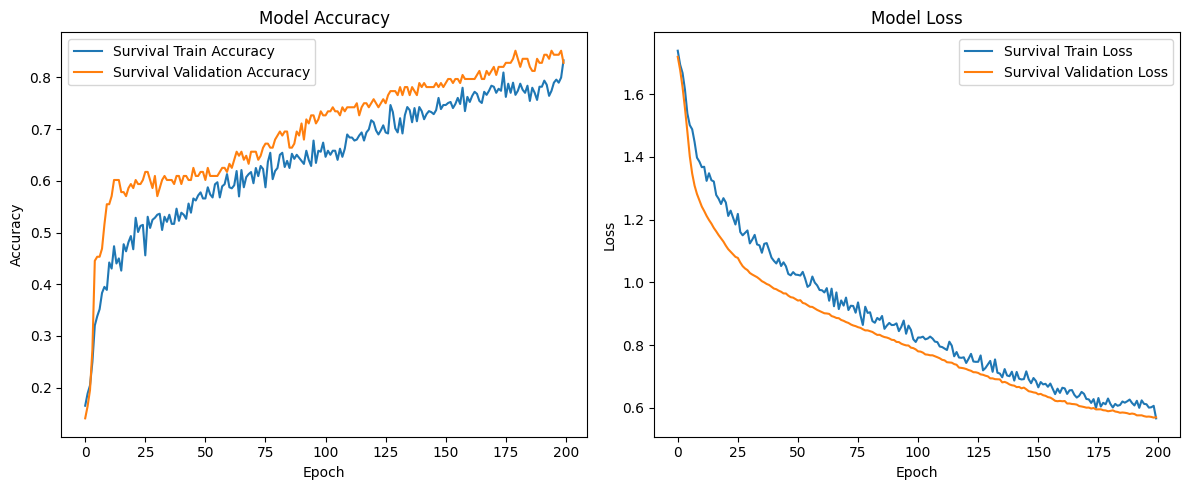

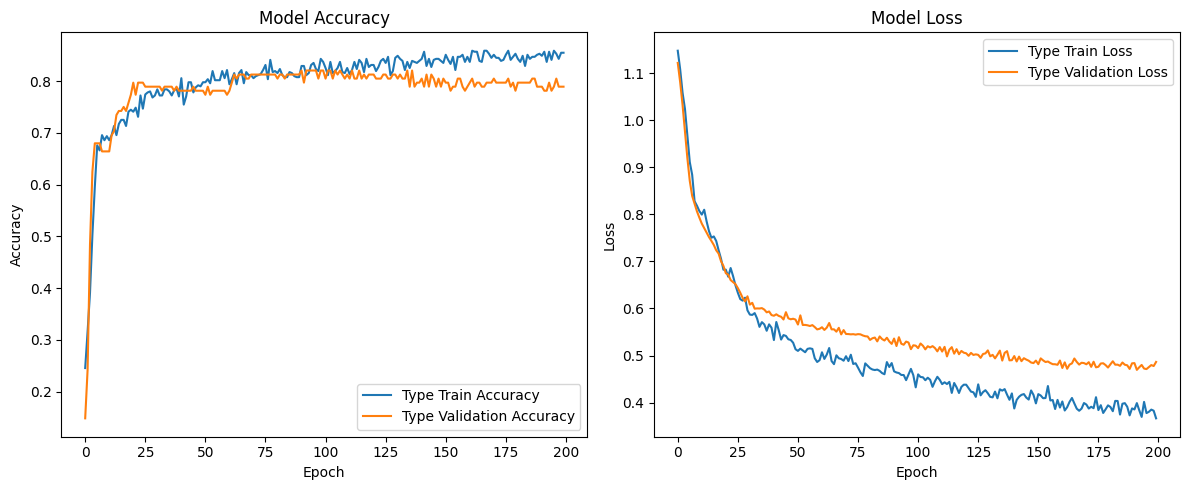

In [30]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğrulukları
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['st_accuracy'], label='Survival Train Accuracy')
plt.plot(history.history['val_st_accuracy'], label='Survival Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Eğitim ve doğrulama kayıpları
plt.subplot(1, 2, 2)
plt.plot(history.history['st_loss'], label='Survival Train Loss')
plt.plot(history.history['val_st_loss'], label='Survival Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğrulukları
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['type_accuracy'], label='Type Train Accuracy')
plt.plot(history.history['val_type_accuracy'], label='Type Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Eğitim ve doğrulama kayıpları
plt.subplot(1, 2, 2)
plt.plot(history.history['type_loss'], label='Type Train Loss')
plt.plot(history.history['val_type_loss'], label='Type Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [68]:
print(y_categorical.shape)

y_true = np.argmax(y_categorical, axis=1)
y_pred = np.argmax(model.predict([X, clinical_data]), axis=1)
print(np.unique(y_true, return_counts=True))
print(np.unique(y_pred, return_counts=True))

print(y_pred)
print(y_true.shape)


(286, 3)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(array([0, 2]), array([185, 101]))
(array([0, 2]), array([216,  70]))
[2 0 0 2 0 0 0 2 0 0 0 0 2 0 0 0 0 2 0 0 2 2 2 0 0 0 0 2 0 0 0 0 2 0 0 0 0
 0 0 2 0 0 2 0 0 2 0 0 2 0 0 0 2 2 2 0 0 0 2 2 0 0 0 0 0 2 0 0 0 0 2 0 0 0
 0 0 0 0 0 0 0 2 2 2 0 2 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 2 2 2 2 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 2 0 2 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 2 2 0 2 2 0 0 0 0 2 2 0 0 2 0 2 0 0 0 0 0 0 0 2 2 0 0 0 0 2
 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 2 0 2 0 0 0
 0 2 0 0 0 0 0 0 2 2 2 0 2 2 0 0 0 2 2 0 0 0 2 0 0 0 2 0 2 0 0 0 0 0 0 0 2
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0]
(286,)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Gerçek sınıflar: (array([0, 1, 2]), array([148, 408,  81]))
Tahmin edilen sınıflar: (array([0, 1, 2]), array([150, 434,  53]))


<Figure size 600x600 with 0 Axes>

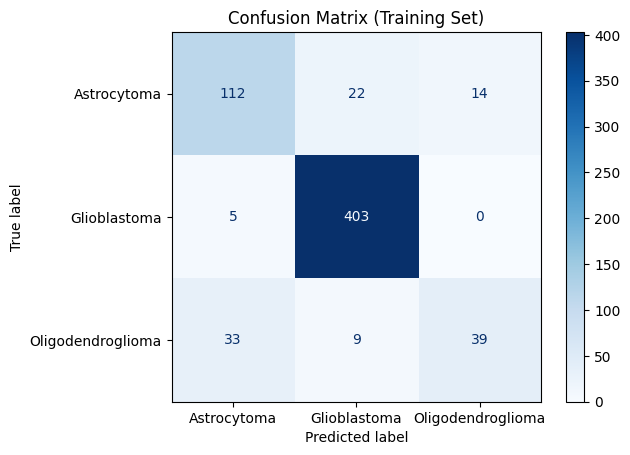

In [135]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Tahminler
y_pred_proba = model.predict([X_train, clinical_train])
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_train, axis=1)

print("Gerçek sınıflar:", np.unique(y_true, return_counts=True))
print("Tahmin edilen sınıflar:", np.unique(y_pred, return_counts=True))

# Sadece mevcut sınıfları kullan
classes_present = np.unique(np.concatenate([y_true, y_pred]))

# Sınıf isimleri
label_names = ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']
labels_to_use = [label_names[i] for i in classes_present]

# Confusion matrix hesapla ve çiz
cm = confusion_matrix(y_true, y_pred, labels=classes_present)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_to_use)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Training Set)")
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


<Figure size 600x600 with 0 Axes>

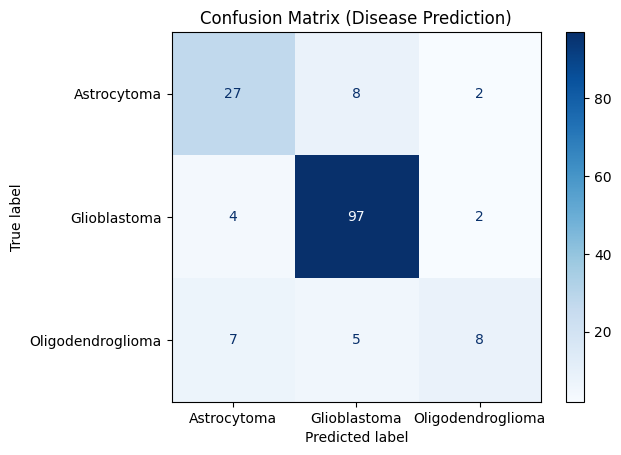

<Figure size 600x600 with 0 Axes>

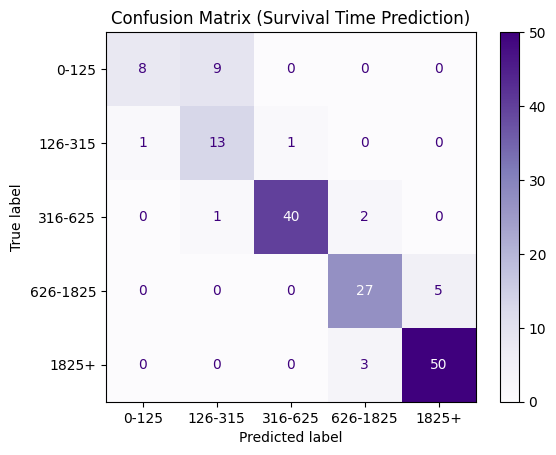

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Model tahminleri (X_test ve clinical_test test verileri)
y_pred_proba = model.predict([X_test, clinical_test])

# Eğer model iki çıktı veriyorsa, y_pred_proba bir liste olur:
# [disease_predictions, survival_time_predictions]

# Her biri için argmax ile sınıf indexlerine çevir
y_pred_1 = np.argmax(y_pred_proba[0], axis=1)  # Hastalık sınıfı tahmini
y_pred_2 = np.argmax(y_pred_proba[1], axis=1)  # Yaşam süresi tahmini

# Ground truth'lar (one-hot -> sınıf indexi)
y_true_1 = np.argmax(y_test, axis=1)
y_true_2 = np.argmax(y2_test, axis=1)

# Sınıf etiketleri
label_names_1 = ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']
label_names_2 = ['0-125', '126-315', '316-625', '626-1825', '1825+']

# -------- 1. Hastalık Confusion Matrix --------
cm1 = confusion_matrix(y_true_1, y_pred_1)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=label_names_1)
plt.figure(figsize=(6, 6))
disp1.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Disease Prediction)")
plt.show()

# -------- 2. Yaşam Süresi Confusion Matrix --------
cm2 = confusion_matrix(y_true_2, y_pred_2)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=label_names_2)
plt.figure(figsize=(6, 6))
disp2.plot(cmap='Purples', values_format='d')
plt.title("Confusion Matrix (Survival Time Prediction)")
plt.show()

